In [145]:
from skimage import data
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

<div dir="rtl">

تصویر دوربین را به عنوان تصویر اصلی بارگذاری می‌کنیم.

</div>

In [146]:
originalImage = data.camera()

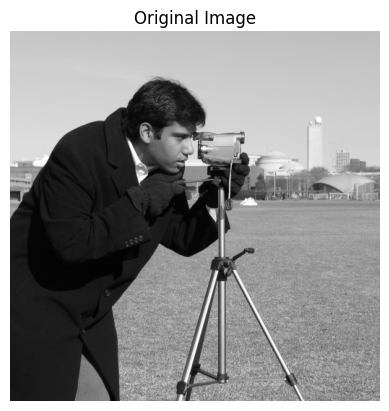

In [147]:
plt.imshow(originalImage, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

<div dir="rtl">

برای شبیه‌سازی داده‌های گمشده به صورت تصادفی تعدادی از پیکسل‌های تصویر را حذف می‌کنیم. ابتدا تصویر را به float تبدیل می‌کنیم تا بتوانیم مقدار NaN را برای پیکسل‌های حذف شده قرار دهیم. سپس برای هر درصد 10 و 20 و 30 به صورت تصادفی پیکسل‌ها را انتخاب کرده و مقدار آنها را NaN قرار می‌دهیم.

</div>

In [ ]:
originalImageFloat = originalImage.astype(float)

np.random.seed(42)

missingPercentages = [10, 20, 30]
corruptedImages = {}

for pct in missingPercentages:
    corrupted = originalImageFloat.copy()
    totalPixels = corrupted.size
    nMissing = int(totalPixels * pct / 100)
    flatIndices = np.random.choice(totalPixels, nMissing, replace=False)
    rows, cols = np.unravel_index(flatIndices, corrupted.shape)
    corrupted[rows, cols] = np.nan
    corruptedImages[pct] = corrupted

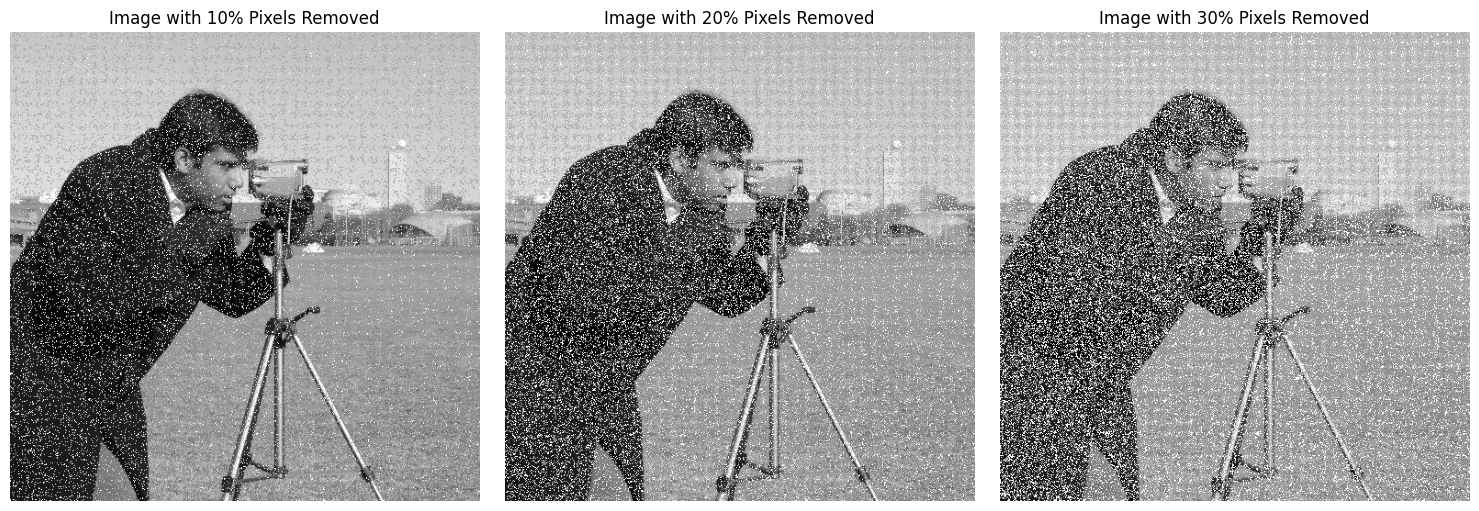

In [149]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, pct in enumerate(missingPercentages):
    axes[idx].imshow(corruptedImages[pct], cmap='gray')
    axes[idx].set_title(f'Image with {pct}% Pixels Removed')
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

<div dir="rtl">

ساده‌ترین روش این است که تمام پیکسل‌های حذف شده را با میانگین پیکسل‌های باقیمانده جایگزین کنیم.

</div>

In [ ]:
reconstructedMean = {}

for pct in missingPercentages:
    corrupted = corruptedImages[pct].copy()
    meanValue = np.nanmean(corrupted)
    reconstructed = corrupted.copy()
    reconstructed[np.isnan(reconstructed)] = meanValue
    reconstructedMean[pct] = reconstructed

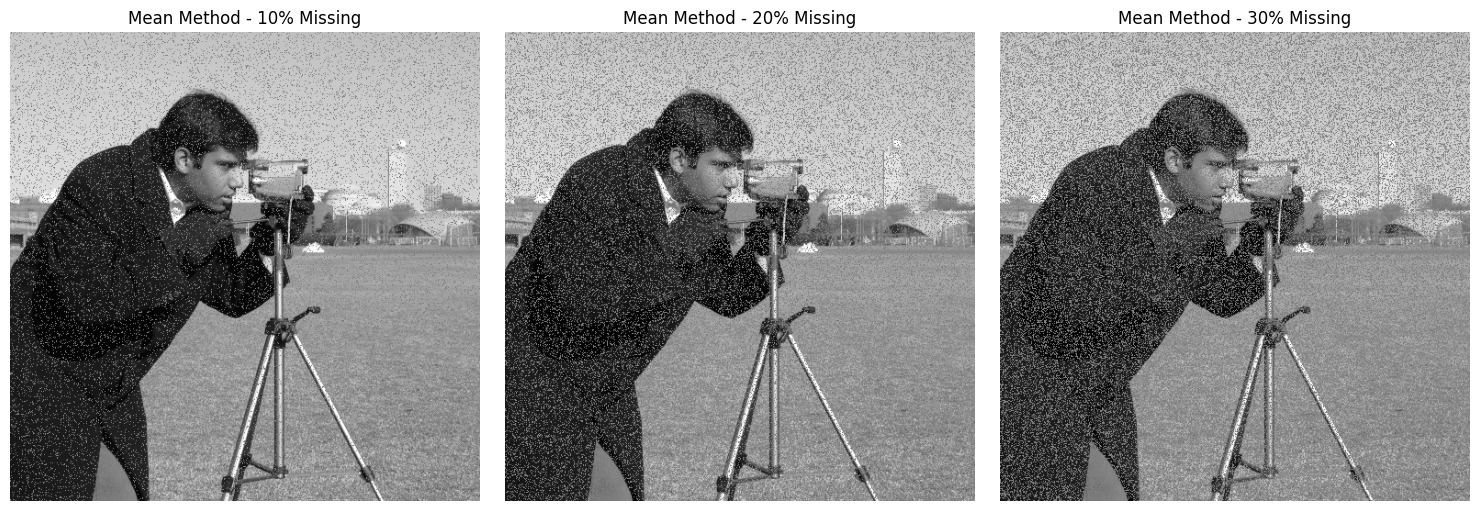

In [151]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, pct in enumerate(missingPercentages):
    axes[idx].imshow(reconstructedMean[pct], cmap='gray')
    axes[idx].set_title(f'Mean Method - {pct}% Missing', fontsize=12)
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

<div dir="rtl">

در این روش به جای یک مقدار ثابت از توزیع نرمال با میانگین و انحراف معیار تصویر مقادیر تصادفی تولید می‌کنیم. این کار باعث می‌شود تصویر بازسازی شده طبیعی‌تر به نظر برسد چون تنوع بیشتری در مقادیر پیکسل‌ها وجود دارد.

</div>

In [ ]:
np.random.seed(42)
reconstructedGaussian = {}

for pct in missingPercentages:
    corrupted = corruptedImages[pct].copy()
    meanValue = np.nanmean(corrupted)
    stdValue = np.nanstd(corrupted)
    mask = np.isnan(corrupted)
    nMissing = np.sum(mask)
    gaussianNoise = np.random.normal(meanValue, stdValue, nMissing)
    gaussianNoise = np.clip(gaussianNoise, 0, 255)
    reconstructed = corrupted.copy()
    reconstructed[mask] = gaussianNoise
    reconstructedGaussian[pct] = reconstructed

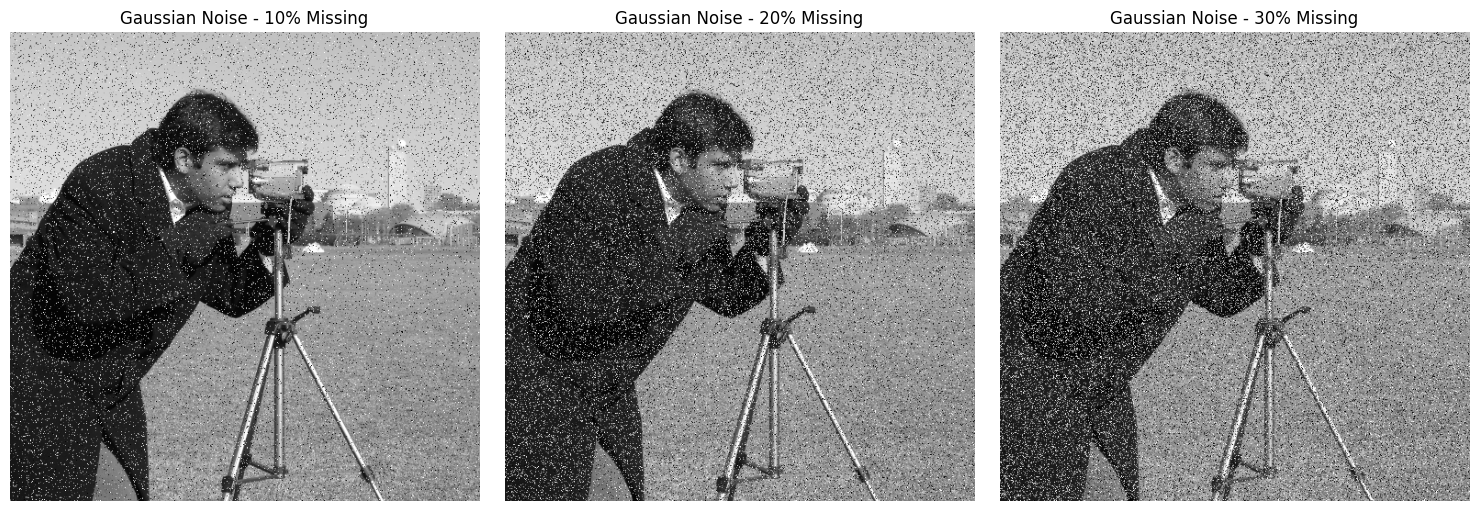

In [153]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, pct in enumerate(missingPercentages):
    axes[idx].imshow(reconstructedGaussian[pct], cmap='gray')
    axes[idx].set_title(f'Gaussian Noise - {pct}% Missing', fontsize=12)
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

<div dir="rtl">

در این روش مقادیر تصادفی از توزیع یکنواخت بین کمترین و بیشترین مقدار پیکسل در تصویر تولید می‌کنیم.

</div>

In [ ]:
np.random.seed(42)
reconstructedUniform = {}

for pct in missingPercentages:
    corrupted = corruptedImages[pct].copy()
    minValue = np.nanmin(corrupted)
    maxValue = np.nanmax(corrupted)
    mask = np.isnan(corrupted)
    nMissing = np.sum(mask)
    uniformNoise = np.random.uniform(minValue, maxValue, nMissing)
    reconstructed = corrupted.copy()
    reconstructed[mask] = uniformNoise
    reconstructedUniform[pct] = reconstructed

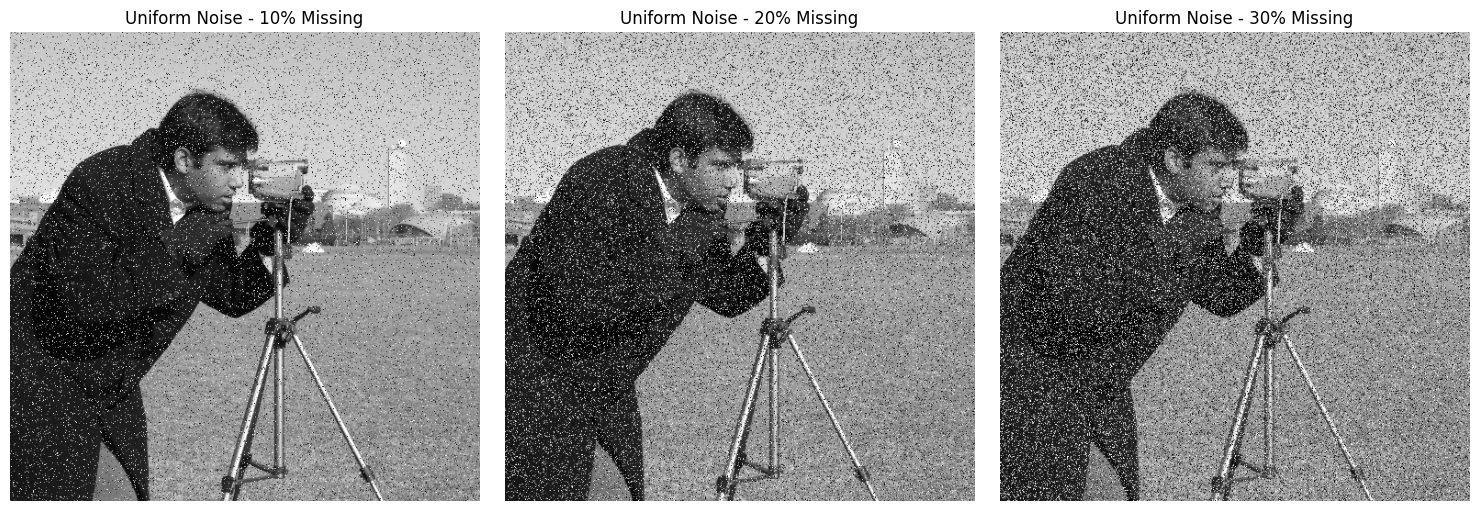

In [155]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, pct in enumerate(missingPercentages):
    axes[idx].imshow(reconstructedUniform[pct], cmap='gray')
    axes[idx].set_title(f'Uniform Noise - {pct}% Missing', fontsize=12)
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

<div dir="rtl">

در این روش از یادگیری ماشین استفاده می‌کنیم. فرض می‌کنیم که مقدار هر پیکسل به موقعیت آن در تصویر بستگی دارد. برای پیکسل‌هایی که مقدارشان معلوم است از موقعیت آنها به عنوان ویژگی و مقدار پیکسل به عنوان هدف استفاده می‌کنیم و یک مدل رگرسیون خطی می‌سازیم. سپس با استفاده از این مدل مقدار پیکسل‌های حذف شده را پیش‌بینی می‌کنیم.

</div>

In [ ]:
reconstructedLinear = {}

for pct in missingPercentages:
    corrupted = corruptedImages[pct].copy()
    rows, cols = np.meshgrid(np.arange(corrupted.shape[0]), np.arange(corrupted.shape[1]), indexing='ij')
    rowsFlat = rows.flatten()
    colsFlat = cols.flatten()
    valuesFlat = corrupted.flatten()
    maskValid = ~np.isnan(valuesFlat)
    xTrain = np.column_stack([rowsFlat[maskValid], colsFlat[maskValid]])
    yTrain = valuesFlat[maskValid]
    xTest = np.column_stack([rowsFlat[~maskValid], colsFlat[~maskValid]])
    model = LinearRegression()
    model.fit(xTrain, yTrain)
    yPred = model.predict(xTest)
    yPred = np.clip(yPred, 0, 255)
    reconstructed = corrupted.copy()
    reconstructedFlat = reconstructed.flatten()
    reconstructedFlat[~maskValid] = yPred
    reconstructed = reconstructedFlat.reshape(corrupted.shape)
    reconstructedLinear[pct] = reconstructed

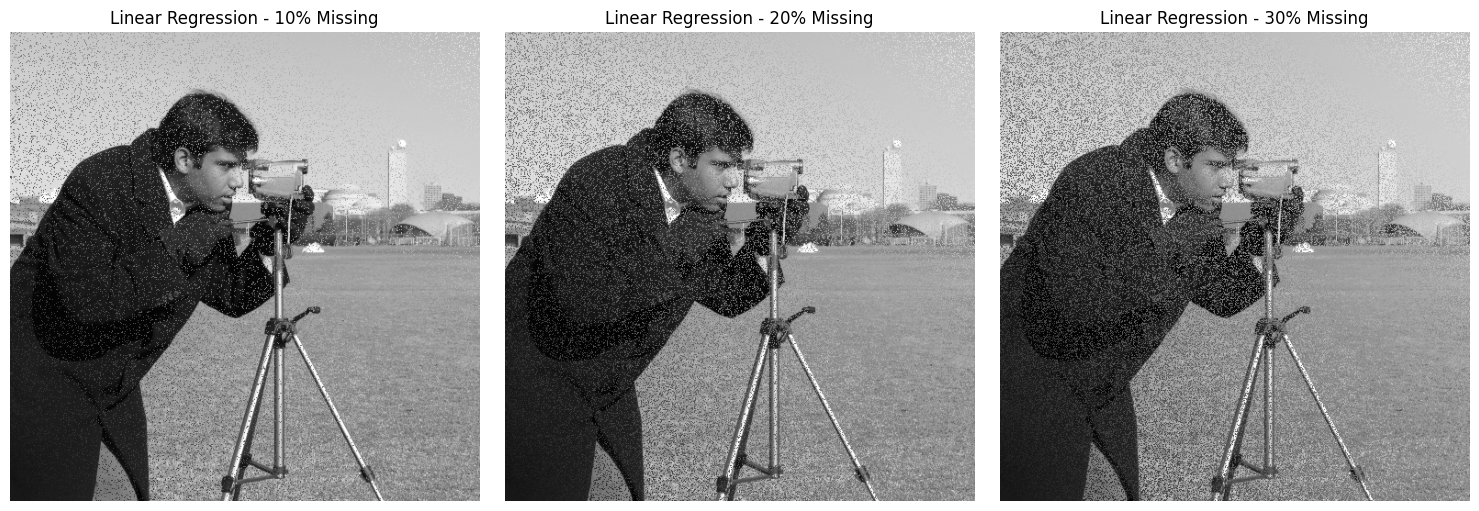

In [157]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, pct in enumerate(missingPercentages):
    axes[idx].imshow(reconstructedLinear[pct], cmap='gray')
    axes[idx].set_title(f'Linear Regression - {pct}% Missing', fontsize=12)
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

<div dir="rtl">

رگرسیون خطی ساده فقط رابطه خطی بین موقعیت و مقدار پیکسل را در نظر می‌گیرد. اما در تصاویر واقعی این رابطه می‌تواند پیچیده‌تر باشد. با استفاده از ویژگی‌های چندجمله‌ای می‌توانیم روابط غیرخطی را هم مدل کنیم. برای مثال با درجه 2 علاوه بر x و y ویژگی‌های x² و y² و xy هم اضافه می‌شوند. درجه‌های بالاتر الگوهای پیچیده‌تری را یاد می‌گیرند اما ممکن است overfitting رخ دهد.

</div>

In [ ]:
polynomialDegrees = range(1, 11)
reconstructedPolynomial = {pct: {} for pct in missingPercentages}

for pct in missingPercentages:
    corrupted = corruptedImages[pct].copy()
    rows, cols = np.meshgrid(np.arange(corrupted.shape[0]), np.arange(corrupted.shape[1]), indexing='ij')
    rowsFlat = rows.flatten()
    colsFlat = cols.flatten()
    valuesFlat = corrupted.flatten()
    maskValid = ~np.isnan(valuesFlat)
    xTrainBase = np.column_stack([rowsFlat[maskValid], colsFlat[maskValid]])
    yTrain = valuesFlat[maskValid]
    xTestBase = np.column_stack([rowsFlat[~maskValid], colsFlat[~maskValid]])
    for degree in polynomialDegrees:
        poly = PolynomialFeatures(degree=degree)
        xTrainPoly = poly.fit_transform(xTrainBase)
        xTestPoly = poly.transform(xTestBase)
        model = LinearRegression()
        model.fit(xTrainPoly, yTrain)
        yPred = model.predict(xTestPoly)
        yPred = np.clip(yPred, 0, 255)
        reconstructed = corrupted.copy()
        reconstructedFlat = reconstructed.flatten()
        reconstructedFlat[~maskValid] = yPred
        reconstructed = reconstructedFlat.reshape(corrupted.shape)
        reconstructedPolynomial[pct][degree] = reconstructed

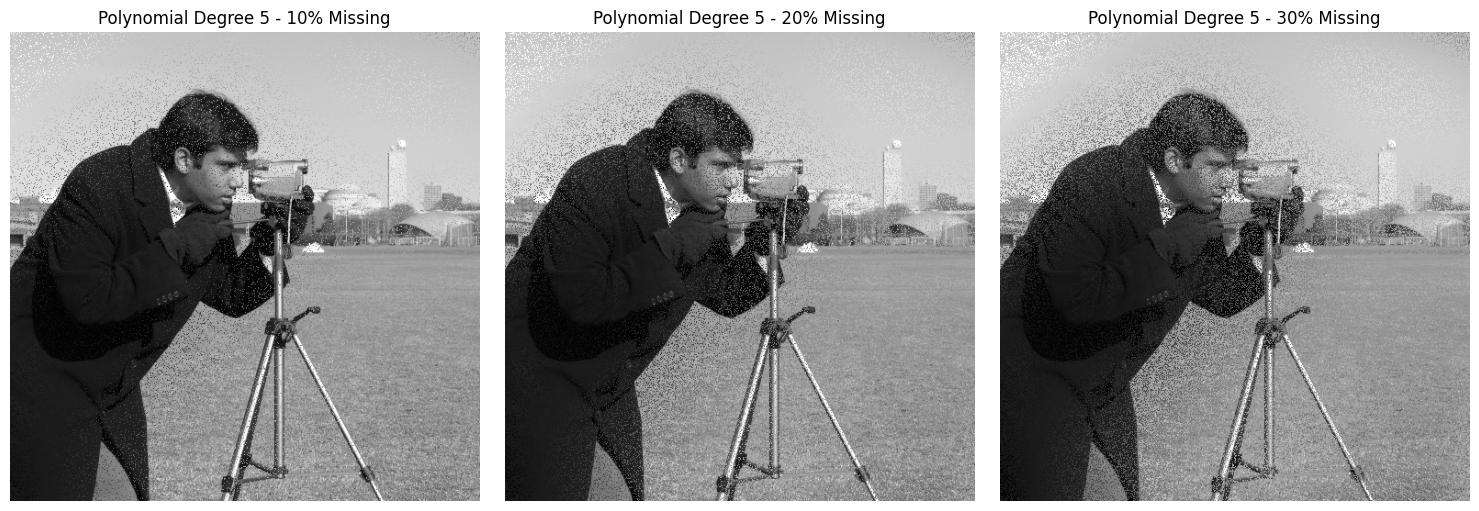

In [159]:
selectedDegree = 5
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, pct in enumerate(missingPercentages):
    axes[idx].imshow(reconstructedPolynomial[pct][selectedDegree], cmap='gray')
    axes[idx].set_title(f'Polynomial Degree {selectedDegree} - {pct}% Missing', fontsize=12)
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

<div dir="rtl">

رگرسیون Ridge شبیه رگرسیون خطی است اما یک جمله منظم‌ساز L2 به تابع هزینه اضافه می‌کند. این کار باعث می‌شود وزن‌های مدل کوچک بمانند و از overfitting جلوگیری شود.

</div>

In [ ]:
reconstructedRidge = {}
for pct in missingPercentages:
    corrupted = corruptedImages[pct].copy()
    rows, cols = np.meshgrid(np.arange(corrupted.shape[0]), np.arange(corrupted.shape[1]), indexing='ij')
    rowsFlat = rows.flatten()
    colsFlat = cols.flatten()
    valuesFlat = corrupted.flatten()
    maskValid = ~np.isnan(valuesFlat)
    xTrain = np.column_stack([rowsFlat[maskValid], colsFlat[maskValid]])
    yTrain = valuesFlat[maskValid]
    xTest = np.column_stack([rowsFlat[~maskValid], colsFlat[~maskValid]])
    model = Ridge()
    model.fit(xTrain, yTrain)
    yPred = model.predict(xTest)
    yPred = np.clip(yPred, 0, 255)
    reconstructed = corrupted.copy()
    reconstructedFlat = reconstructed.flatten()
    reconstructedFlat[~maskValid] = yPred
    reconstructed = reconstructedFlat.reshape(corrupted.shape)
    reconstructedRidge[pct] = reconstructed

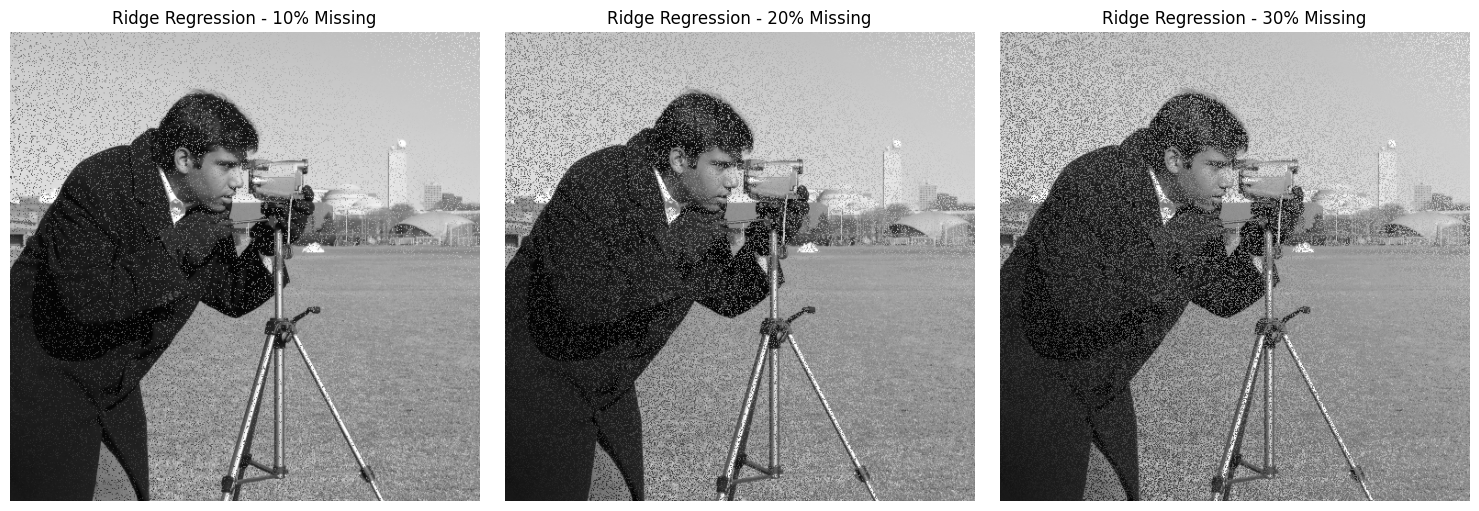

In [161]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, pct in enumerate(missingPercentages):
    axes[idx].imshow(reconstructedRidge[pct], cmap='gray')
    axes[idx].set_title(f'Ridge Regression - {pct}% Missing', fontsize=12)
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

<div dir="rtl">

رگرسیون Lasso هم مانند Ridge یک روش منظم‌سازی شده است اما از جریمه L1 استفاده می‌کند. تفاوت اصلی این است که Lasso می‌تواند برخی وزن‌ها را دقیقا صفر کند و به این ترتیب انتخاب ویژگی انجام دهد.

</div>

In [ ]:
reconstructedLasso = {}

for pct in missingPercentages:
    corrupted = corruptedImages[pct].copy()
    rows, cols = np.meshgrid(np.arange(corrupted.shape[0]), np.arange(corrupted.shape[1]), indexing='ij')
    rowsFlat = rows.flatten()
    colsFlat = cols.flatten()
    valuesFlat = corrupted.flatten()
    maskValid = ~np.isnan(valuesFlat)
    xTrain = np.column_stack([rowsFlat[maskValid], colsFlat[maskValid]])
    yTrain = valuesFlat[maskValid]
    xTest = np.column_stack([rowsFlat[~maskValid], colsFlat[~maskValid]])
    model = Lasso()
    model.fit(xTrain, yTrain)
    yPred = model.predict(xTest)
    yPred = np.clip(yPred, 0, 255)
    reconstructed = corrupted.copy()
    reconstructedFlat = reconstructed.flatten()
    reconstructedFlat[~maskValid] = yPred
    reconstructed = reconstructedFlat.reshape(corrupted.shape)
    reconstructedLasso[pct] = reconstructed

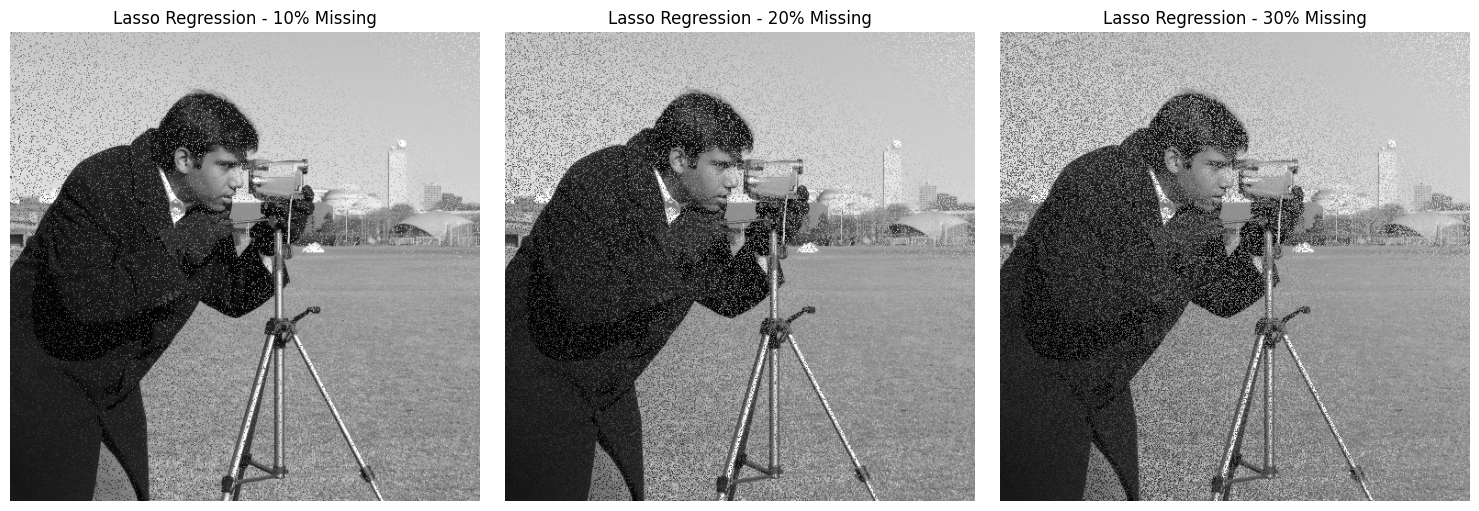

In [163]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, pct in enumerate(missingPercentages):
    axes[idx].imshow(reconstructedLasso[pct], cmap='gray')
    axes[idx].set_title(f'Lasso Regression - {pct}% Missing', fontsize=12)
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

<div dir="rtl">

برای مقایسه کیفیت روش‌های مختلف از معیار SSIM استفاده می‌کنیم. این معیار شباهت ساختاری بین دو تصویر را اندازه می‌گیرد و مقداری بین منفی یک تا یک دارد که هر چه به یک نزدیک‌تر باشد یعنی تصاویر شبیه‌تر هستند. SSIM بهتر از معیارهای ساده مثل MSE است چون نحوه درک انسان از کیفیت تصویر را بهتر مدل می‌کند.

</div>

In [ ]:
results = []

for pct in missingPercentages:
    ssimMean = ssim(originalImageFloat, reconstructedMean[pct], data_range=255)
    results.append({'Missing %': pct, 'Method': 'Mean', 'SSIM': ssimMean})
    
    ssimGaussian = ssim(originalImageFloat, reconstructedGaussian[pct], data_range=255)
    results.append({'Missing %': pct, 'Method': 'Gaussian Noise', 'SSIM': ssimGaussian})
    
    ssimUniform = ssim(originalImageFloat, reconstructedUniform[pct], data_range=255)
    results.append({'Missing %': pct, 'Method': 'Uniform Noise', 'SSIM': ssimUniform})
    
    ssimLinear = ssim(originalImageFloat, reconstructedLinear[pct], data_range=255)
    results.append({'Missing %': pct, 'Method': 'Linear Regression', 'SSIM': ssimLinear})
    
    for degree in polynomialDegrees:
        ssimPoly = ssim(originalImageFloat, reconstructedPolynomial[pct][degree], data_range=255)
        results.append({'Missing %': pct, 'Method': f'Polynomial deg={degree}', 'SSIM': ssimPoly})
    
    ssimRidge = ssim(originalImageFloat, reconstructedRidge[pct], data_range=255)
    results.append({'Missing %': pct, 'Method': 'Ridge', 'SSIM': ssimRidge})
    
    ssimLasso = ssim(originalImageFloat, reconstructedLasso[pct], data_range=255)
    results.append({'Missing %': pct, 'Method': 'Lasso', 'SSIM': ssimLasso})

resultsDF = pd.DataFrame(results)

<div dir="rtl">

در جدول زیر می‌توانیم SSIM هر روش را برای درصدهای مختلف داده گمشده مشاهده کنیم.

</div>

In [165]:
pivotTable = resultsDF.pivot(index='Method', columns='Missing %', values='SSIM')
print("SSIM Comparison Table by Missing Percentage:\n")
print(pivotTable.to_string())
print("\n" + "="*80)

SSIM Comparison Table by Missing Percentage:

Missing %                10        20        30
Method                                         
Gaussian Noise     0.304365  0.185038  0.133419
Lasso              0.563365  0.460909  0.403168
Linear Regression  0.563390  0.460934  0.403193
Mean               0.437677  0.352418  0.304034
Polynomial deg=1   0.563390  0.460934  0.403193
Polynomial deg=10  0.589417  0.497286  0.442582
Polynomial deg=2   0.595985  0.485864  0.423668
Polynomial deg=3   0.670710  0.566567  0.505962
Polynomial deg=4   0.708577  0.607741  0.546240
Polynomial deg=5   0.721236  0.623233  0.562708
Polynomial deg=6   0.724277  0.624476  0.564194
Polynomial deg=7   0.620595  0.520810  0.461960
Polynomial deg=8   0.615904  0.519968  0.462899
Polynomial deg=9   0.604516  0.509911  0.453749
Ridge              0.563390  0.460934  0.403193
Uniform Noise      0.288981  0.172633  0.122367



In [ ]:
print("Best Method for Each Missing Percentage:\n")
for pct in missingPercentages:
    subset = resultsDF[resultsDF['Missing %'] == pct]
    bestMethod = subset.loc[subset['SSIM'].idxmax()]
    print(f"{pct}% Missing: {bestMethod['Method']} (SSIM = {bestMethod['SSIM']:.4f})")

<div dir="rtl">

می‌بینیم که روش‌های مبتنی بر نویز عملکرد بسیار ضعیفی دارند چون هیچ اطلاعاتی از ساختار تصویر استفاده نمی‌کنند. روش میانگین بهتر است اما همچنان ساده است. روش‌های رگرسیونی با یادگیری رابطه بین موقعیت و مقدار پیکسل نتایج بهتری می‌دهند. همانطور که انتظار داریم با افزایش درصد داده گمشده کیفیت بازسازی در تمام روش‌ها کاهش می‌یابد.

</div>

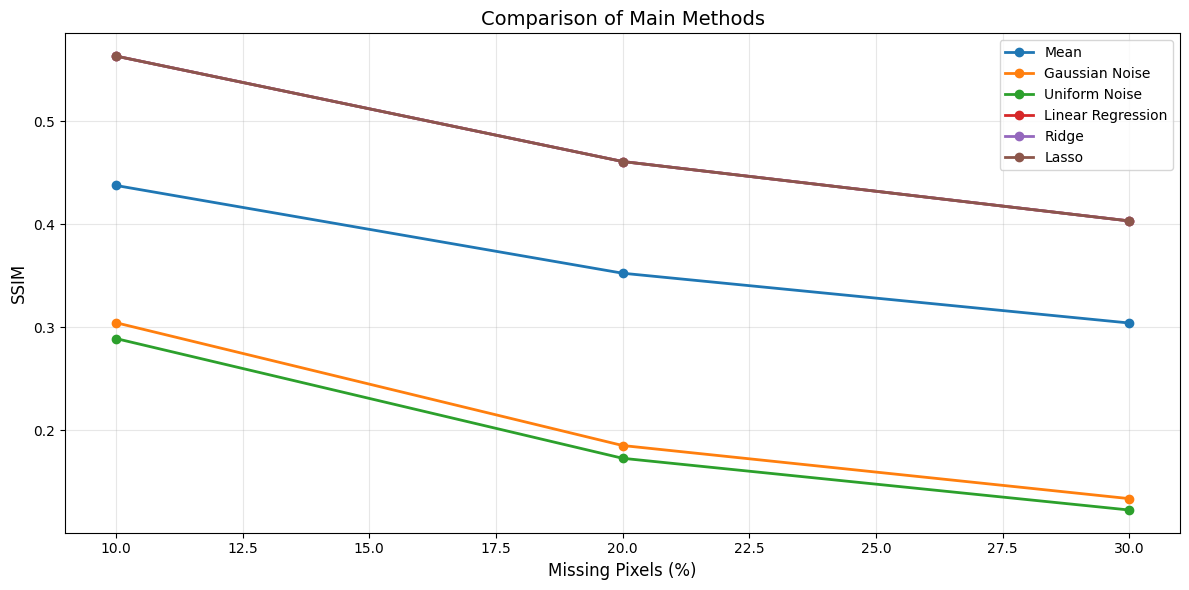

In [167]:
mainMethods = ['Mean', 'Gaussian Noise', 'Uniform Noise', 'Linear Regression', 'Ridge', 'Lasso']
mainResults = resultsDF[resultsDF['Method'].isin(mainMethods)]

plt.figure(figsize=(12, 6))
for method in mainMethods:
    methodData = mainResults[mainResults['Method'] == method]
    plt.plot(methodData['Missing %'], methodData['SSIM'], marker='o', label=method, linewidth=2)

plt.xlabel('Missing Pixels (%)', fontsize=12)
plt.ylabel('SSIM', fontsize=12)
plt.title('Comparison of Main Methods', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
polyResults = resultsDF[resultsDF['Method'].str.contains('Polynomial')]

plt.figure(figsize=(12, 6))
for degree in polynomialDegrees:
    methodName = f'Polynomial deg={degree}'
    methodData = polyResults[polyResults['Method'] == methodName]
    plt.plot(methodData['Missing %'], methodData['SSIM'], marker='o', label=f'Degree {degree}', linewidth=2)

plt.xlabel('Missing Pixels (%)', fontsize=12)
plt.ylabel('SSIM', fontsize=12)
plt.title('Comparison of Polynomial Regression with Different Degrees', fontsize=14)
plt.legend(ncol=2, fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<div dir="rtl">

در نمودار رگرسیون چندجمله‌ای می‌بینیم که با افزایش درجه تا 5 یا 6 کیفیت بهبود می‌یابد اما بعد از آن دوباره کاهش می‌یابد. این پدیده نشان‌دهنده overfitting است. درجه‌های خیلی بالا الگوهای پیچیده‌ای یاد می‌گیرند که مخصوص داده‌های آموزشی هستند و به داده‌های جدید تعمیم نمی‌یابند. بنابراین درجه 6 به عنوان بهترین انتخاب شناخته می‌شود که تعادل خوبی بین پیچیدگی مدل و قابلیت تعمیم دارد.

</div>

<div dir="rtl">

برای درک بهتر کیفیت بازسازی نمونه‌ای از تصاویر بازسازی شده با روش‌های مختلف را نمایش می‌دهیم.

</div>

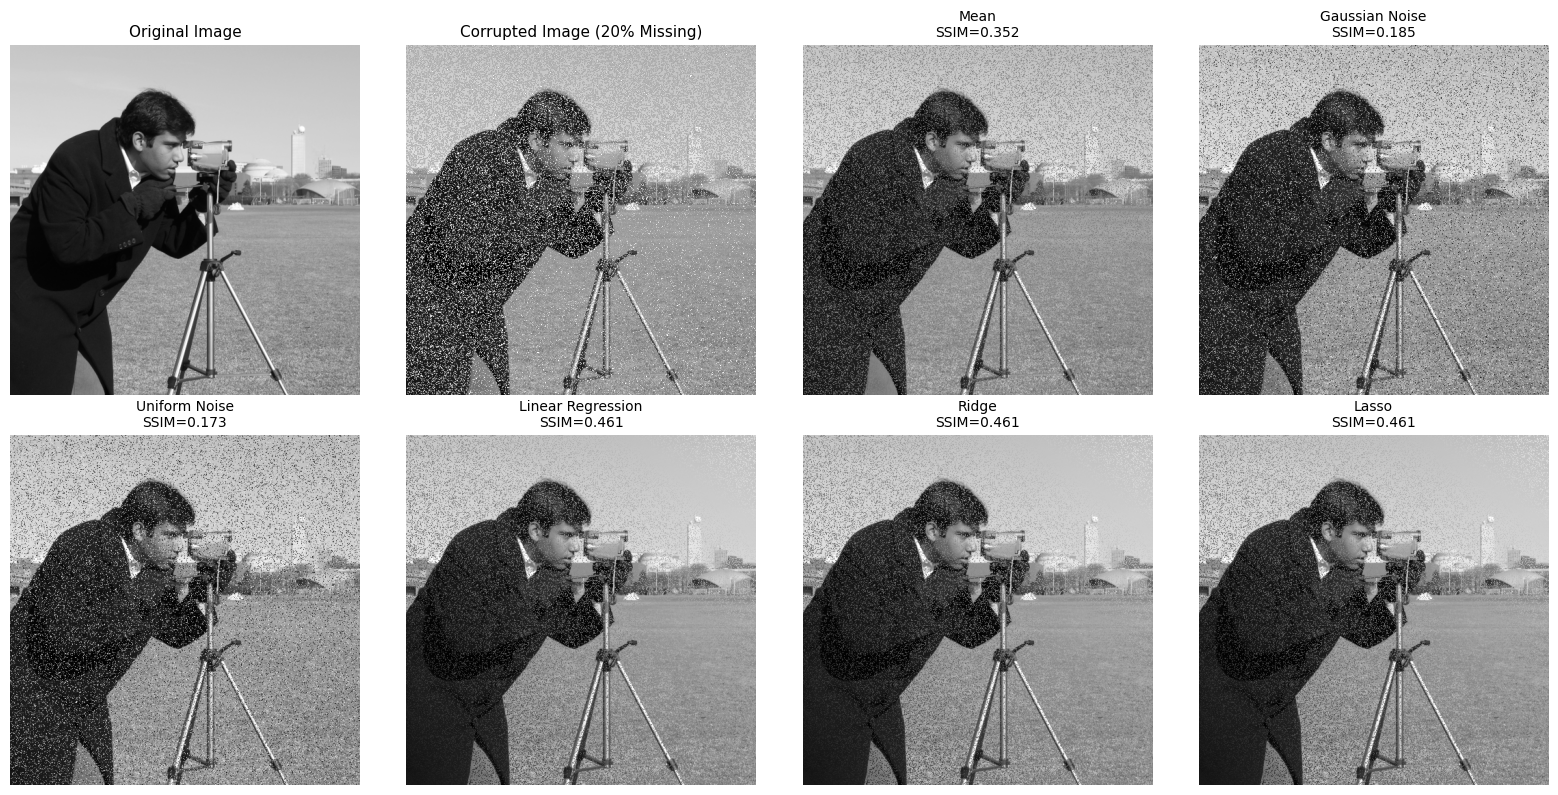

In [169]:
pctShow = 20

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

axes[0].imshow(originalImage, cmap='gray')
axes[0].set_title('Original Image', fontsize=11)
axes[0].axis('off')

axes[1].imshow(corruptedImages[pctShow], cmap='gray')
axes[1].set_title(f'Corrupted Image ({pctShow}% Missing)', fontsize=11)
axes[1].axis('off')

axes[2].imshow(reconstructedMean[pctShow], cmap='gray')
ssimVal = resultsDF[(resultsDF['Missing %'] == pctShow) & (resultsDF['Method'] == 'Mean')]['SSIM'].values[0]
axes[2].set_title(f'Mean\nSSIM={ssimVal:.3f}', fontsize=10)
axes[2].axis('off')

axes[3].imshow(reconstructedGaussian[pctShow], cmap='gray')
ssimVal = resultsDF[(resultsDF['Missing %'] == pctShow) & (resultsDF['Method'] == 'Gaussian Noise')]['SSIM'].values[0]
axes[3].set_title(f'Gaussian Noise\nSSIM={ssimVal:.3f}', fontsize=10)
axes[3].axis('off')

axes[4].imshow(reconstructedUniform[pctShow], cmap='gray')
ssimVal = resultsDF[(resultsDF['Missing %'] == pctShow) & (resultsDF['Method'] == 'Uniform Noise')]['SSIM'].values[0]
axes[4].set_title(f'Uniform Noise\nSSIM={ssimVal:.3f}', fontsize=10)
axes[4].axis('off')

axes[5].imshow(reconstructedLinear[pctShow], cmap='gray')
ssimVal = resultsDF[(resultsDF['Missing %'] == pctShow) & (resultsDF['Method'] == 'Linear Regression')]['SSIM'].values[0]
axes[5].set_title(f'Linear Regression\nSSIM={ssimVal:.3f}', fontsize=10)
axes[5].axis('off')

axes[6].imshow(reconstructedRidge[pctShow], cmap='gray')
ssimVal = resultsDF[(resultsDF['Missing %'] == pctShow) & (resultsDF['Method'] == 'Ridge')]['SSIM'].values[0]
axes[6].set_title(f'Ridge\nSSIM={ssimVal:.3f}', fontsize=10)
axes[6].axis('off')

axes[7].imshow(reconstructedLasso[pctShow], cmap='gray')
ssimVal = resultsDF[(resultsDF['Missing %'] == pctShow) & (resultsDF['Method'] == 'Lasso')]['SSIM'].values[0]
axes[7].set_title(f'Lasso\nSSIM={ssimVal:.3f}', fontsize=10)
axes[7].axis('off')

plt.tight_layout()
plt.show()